In [1]:
%reset -sf

import tensorflow as tf
import tf_keras
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)

# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        # memory_limit = 16_376 / 2 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2025-02-09 15:35:22.425211: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 15:35:22.448867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
Tensorflow Probability: 0.24.0
1 Physical GPUs, 1 Logical GPU


2025-02-09 15:35:24.145069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import atlas_plot as ap

plot = ap.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [4]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > -9999
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [5]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()

In [6]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        lead_lep.pz,
        lead_lep.energy,
        sublead_lep.px,
        sublead_lep.py,
        sublead_lep.pz,
        sublead_lep.energy,
        # np.log(sublead_lep.energy),
        # np.log(lead_lep.energy),
        # lead_lep.eta,
        # sublead_lep.eta,
        met.px,
        met.py,
    )
)[PRE_CUT]

# weights
mc_weight = mc_weight.w.to_numpy()[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

# ROBUST_OBS = RobustScaler()
# obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 10)


In [7]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        # w_lead_m,
        # w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 8)
<class 'numpy.ndarray'>


In [8]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 8);
Validing data shape: (85111, 8);
Testing data shape: (85112, 8).


In [9]:
# training variables
BATCH_SIZE = 512
EPOCHS = 1024
LEARNING_RATE = 1e-5

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_x, tf.float32), 
    tf.cast(train_y, tf.float32)
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(valid_x, tf.float32), 
    tf.cast(valid_y, tf.float32)
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
class CustomModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # Separate trackers for each loss type
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.val_loss_tracker = tf.keras.metrics.Mean(name='val_loss')
        self.mass_metric = tf.keras.metrics.Mean(name='mass_loss')
        self.higgs_mass_metric = tf.keras.metrics.Mean(name='higgs_mass_loss')
        self.mse_metric = tf.keras.metrics.Mean(name='mse_loss')

    def call(self, inputs, training=None):
        # Implement forward pass
        return self.base_model(inputs, training=training)
    
    def compile(self, optimizer, mse_weight=1.0, mass_weight=1.0, higgs_mass_weight=1.0,**kwargs):
        super().compile(optimizer=optimizer, **kwargs)
        self.mse_weight = mse_weight
        self.mass_weight = mass_weight
        self.higgs_mass_weight = higgs_mass_weight

    @property # initialization!!
    def metrics(self):
        return [
            self.loss_tracker,
            self.val_loss_tracker,
            self.mass_metric,
            self.mse_metric,
            self.higgs_mass_metric
        ]
    
    def train_step(self, data):
        x, y = data
        
        with tf.GradientTape() as tape:
            predictions = self.base_model(x, training=True)
            mse = mse_loss(y, predictions)
            mass = mass_loss(x, predictions)
            higgs_mass = higgs_mass_loss(predictions)
            
            # Compute total loss
            total_loss = (
                self.mse_weight * mse +
                self.mass_weight * mass +
                self.higgs_mass_weight * higgs_mass
            )
        
        # Compute gradients for all losses at once
        trainable_vars = self.base_model.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        
        # Apply gradients in one step
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.mass_metric.update_state(mass)
        self.mse_metric.update_state(mse)
        self.higgs_mass_metric.update_state(higgs_mass)
        self.loss_tracker.update_state(total_loss)
        
        return {
            "loss": self.loss_tracker.result(),
            "mass_loss": self.mass_metric.result(),
            "mse_loss": self.mse_metric.result(),
            "higgs_mass_loss": self.higgs_mass_metric.result()
        }

    # def train_step(self, data):
    #     x, y = data
        
    #     with tf.GradientTape(persistent=True) as tape:
    #         predictions = self.base_model(x, training=True)
    #         # Calculate individual losses
    #         mse = mse_loss(y, predictions)
    #         mass = mass_loss(x, predictions)
    #         higgs_mass = higgs_mass_loss(predictions)
        
    #     # Get trainable variables
    #     trainable_vars = self.base_model.trainable_variables
        
    #     # Calculate and apply gradients for each loss
    #     if self.mse_weight > 0:
    #         mse_grads = tape.gradient(mse, trainable_vars)
    #         self.optimizer.apply_gradients(zip(mse_grads, trainable_vars))
    #     if self.mass_weight > 0:
    #         mass_grads = tape.gradient(mass, trainable_vars)
    #         self.optimizer.apply_gradients(zip(mass_grads, trainable_vars))
    #     if self.higgs_mass_weight > 0:
    #         higgs_mass_grads = tape.gradient(higgs_mass, trainable_vars)
    #         self.optimizer.apply_gradients(zip(higgs_mass_grads, trainable_vars))
    #     if self.mse_weight <= 0 and self.mass_weight <= 0 and self.higgs_mass_weight <= 0:
    #         raise ValueError("At least one of weights must be greater than 0")
        
    #     # Clean up tape
    #     del tape
        
    #     # Update metrics
    #     self.mass_metric.update_state(mass)
    #     self.mse_metric.update_state(mse)
    #     self.higgs_mass_metric.update_state(higgs_mass)
    #     # Update loss tracker with weighted sum of losses
    #     total_loss = self.mse_weight * mse + self.mass_weight * mass + self.higgs_mass_weight * higgs_mass
    #     self.loss_tracker.update_state(total_loss)
        
    #     return {
    #         "loss": self.loss_tracker.result(),
    #         "mass_loss": self.mass_metric.result(),
    #         "mse_loss": self.mse_metric.result(),
    #         "higgs_mass_loss": self.higgs_mass_metric.result()
    #     }
        
    def test_step(self, data):
        x, y = data
        predictions = self.base_model(x, training=False)
        mse = mse_loss(y, predictions)
        mass = mass_loss(x, predictions)
        higgs_mass = higgs_mass_loss(predictions)
        total_loss = self.mse_weight * mse + self.mass_weight * mass + self.higgs_mass_weight * higgs_mass
        self.val_loss_tracker.update_state(total_loss)
        return {
            "loss": self.val_loss_tracker.result(),
            "mass_loss": mass,
            "mse_loss": mse,
            "higgs_mass_loss": higgs_mass
        }

def mass_loss(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32) #leps info
    y_pred = tf.cast(y_pred, tf.float32)   # Ws info
    
    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]
    
    nu0_mass = tf.sqrt(
            tf.math.maximum(
                tf.abs(tf.square(n0_4vect[..., 3]) - tf.reduce_sum(tf.square(n0_4vect[..., :3]), axis=-1)), _epsilon
            )
        )
    nu1_mass = tf.sqrt(
            tf.math.maximum(
                tf.abs(tf.square(n1_4vect[..., 3]) - tf.reduce_sum(tf.square(n1_4vect[..., :3]), axis=-1)), _epsilon
            )
        )
    
    return tf.reduce_mean(nu0_mass + nu1_mass)


def higgs_mass_loss(y_pred):
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)
    
    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    higgs_4Vect = w0_4Vect + w1_4Vect
    
    higgs_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(higgs_4Vect[..., 3]) - tf.reduce_sum(tf.square(higgs_4Vect[..., :3]), axis=-1)), _epsilon
        )
    )
    
    return tf.reduce_mean(tf.abs(higgs_mass - 125.0)) + _epsilon


def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.keras.losses.mae(y_true, y_pred))

In [ ]:
def dense_dropout_block(x, units, activation="selu", dropout_rate=0.0, l2=0.0):
    x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=tf.keras.regularizers.L2(l2=l2),
        use_bias=True,
    )(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    return x

def residual_block(x, units, activation="selu", dropout_rate=0.0, l2=0.0):
    y = dense_dropout_block(x, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(y, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(y, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    # Project shortcut if dimensions don't match
    if x.shape[-1] != units:
        x = tf.keras.layers.Dense(units, activation=None, use_bias=False)(x)
    z = tf.keras.layers.Add()([x, y])  # Use the unmodified residual
    return z

def build_model(input_shape):
    inputs = tf.keras.layers.Input(shape=(input_shape,), dtype=tf.float32)
    x = inputs
    
    for _ in range(3):
        x = residual_block(x, 1024, dropout_rate=0.2)
        x = residual_block(x, 512, dropout_rate=0.0)
    for _ in range(3):
        x = residual_block(x, 256, dropout_rate=0.02)
        x = residual_block(x, 128, dropout_rate=0.0)
        
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(32, activation='selu', kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
    x = tf.keras.layers.Dense(64, activation='selu')(x)
    outputs = tf.keras.layers.Dense(units=8, activation="linear")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:

# Build and compile model
base_model = build_model(train_x.shape[-1])
model = CustomModel(base_model)

# Model compilation with weights for each loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    mse_weight=8.0,
    mass_weight=1.8,
    higgs_mass_weight=0.6,
    jit_compile=True
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,
    #     patience=10,
    #     min_lr=1e-6
    # ),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir='logs',
    #     histogram_freq=1
    # )
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/1024
1330/1330 - 43s - 33ms/step - higgs_mass_loss: 121.7598 - loss: 625.8034 - mass_loss: 8.5619 - mse_loss: 67.4880 - val_higgs_mass_loss: 121.2287 - val_loss: 619.0081 - val_mass_loss: 6.2666 - val_mse_loss: 68.3804
Epoch 2/1024
1330/1330 - 12s - 9ms/step - higgs_mass_loss: 121.0881 - loss: 621.0544 - mass_loss: 6.7784 - mse_loss: 67.2793 - val_higgs_mass_loss: 120.6968 - val_loss: 616.1149 - val_mass_loss: 5.6727 - val_mse_loss: 68.1968
Epoch 3/1024
1330/1330 - 11s - 8ms/step - higgs_mass_loss: 120.5946 - loss: 619.2414 - mass_loss: 6.7493 - mse_loss: 67.0951 - val_higgs_mass_loss: 120.2819 - val_loss: 614.5663 - val_mass_loss: 5.7663 - val_mse_loss: 68.0035
Epoch 4/1024
1330/1330 - 11s - 9ms/step - higgs_mass_loss: 120.1894 - loss: 617.5480 - mass_loss: 6.7709 - mse_loss: 66.9097 - val_higgs_mass_loss: 119.8901 - val_loss: 612.9332 - val_mass_loss: 5.7630 - val_mse_loss: 67.7980
Epoch 5/1024
1330/1330 - 11s - 9ms/step - higgs_mass_loss: 119.7996 - loss: 615.9553 - mass_los

I0000 00:00:1739115334.963724 3223631 service.cc:145] XLA service 0x795bf4003c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739115334.963743 3223631 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-02-09 15:35:35.141058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-09 15:35:35.869038: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1739115347.414552 3223631 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_46', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_43', 8 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memor

In [13]:
# Make a directory
dir_name = HOME_PATH + "/10th_trial/ww_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/10th_trial/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/10th_trial/ww_resregressor_result/ exists.


/root/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_resregressor_result/saved_model/assets


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


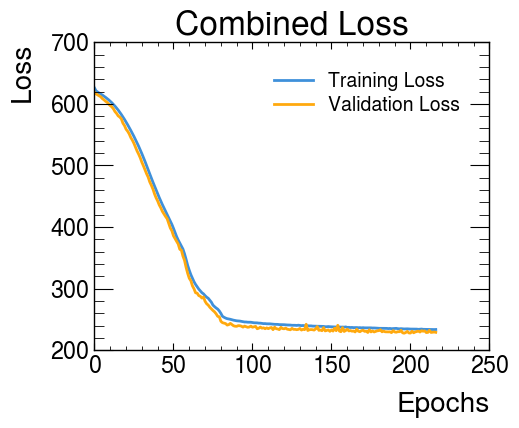

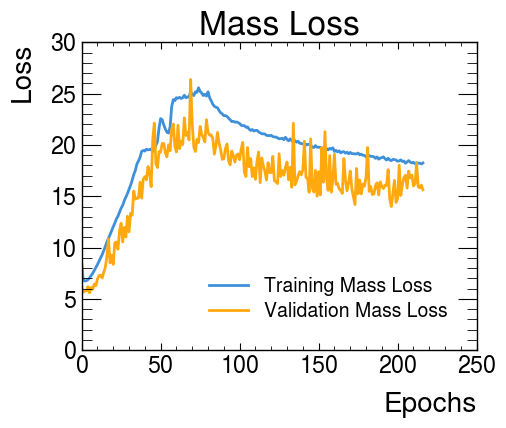

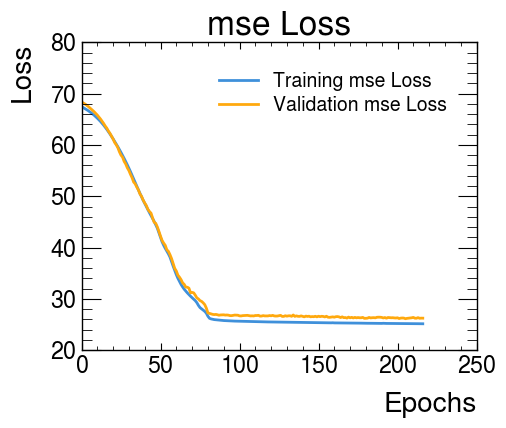

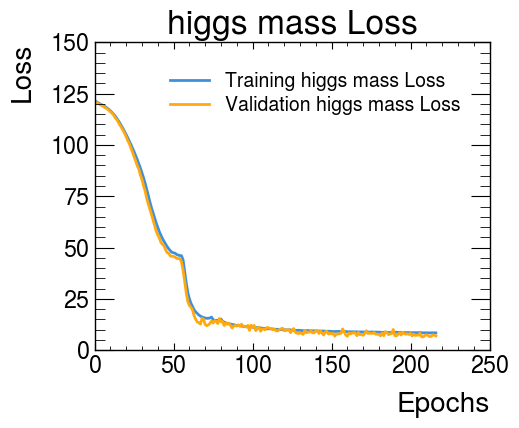

In [14]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mass_loss = history.history["mass_loss"]
val_mass_loss = history.history["val_mass_loss"]
mse_loss = history.history["mse_loss"]
val_mse_loss = history.history["val_mse_loss"]
higgs_mass_loss = history.history["higgs_mass_loss"]
val_higgs_mass_loss = history.history["val_higgs_mass_loss"]

# 1) Plot combined training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss")
plt.legend()
plt.grid(False)
plt.show()

# 2) Plot mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mass_loss, label="Training Mass Loss")
plt.plot(val_mass_loss, label="Validation Mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 3) Plot mse training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mse_loss, label="Training mse Loss")
plt.plot(val_mse_loss, label="Validation mse Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("mse Loss")
plt.legend()
plt.grid(False)
plt.show()

# 4) Plot higgs mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(higgs_mass_loss, label="Training higgs mass Loss")
plt.plot(val_higgs_mass_loss, label="Validation higgs mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("higgs mass Loss")
plt.legend()
plt.grid(False)
plt.show()

In [15]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 1.000e+01, 1.300e+01,
        4.600e+01, 3.150e+02, 3.638e+04, 4.763e+04, 5.220e+02, 9.900e+01,
        2.900e+01, 1.800e+01, 1.200e+01, 3.000e+00, 4.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.16003172e+04, -1.11703652e+04, -1.07404132e+04, -1.03104611e+04,
        -9.88050908e+03, -9.45055705e+03, -9.02060501e+03, -8.59065298e+03,
        -8.16070095e+03, -7.73074891e+03, -7.30079688e+03, -6.87084484e+03,
        -6.44089281e+03, -6.01094077e+03, -5.58098874e+03, -5.15103670e+03,
        -4.72108467e+03, -4.29113263e+03, -3.86118060e+03, -3.43122857e+

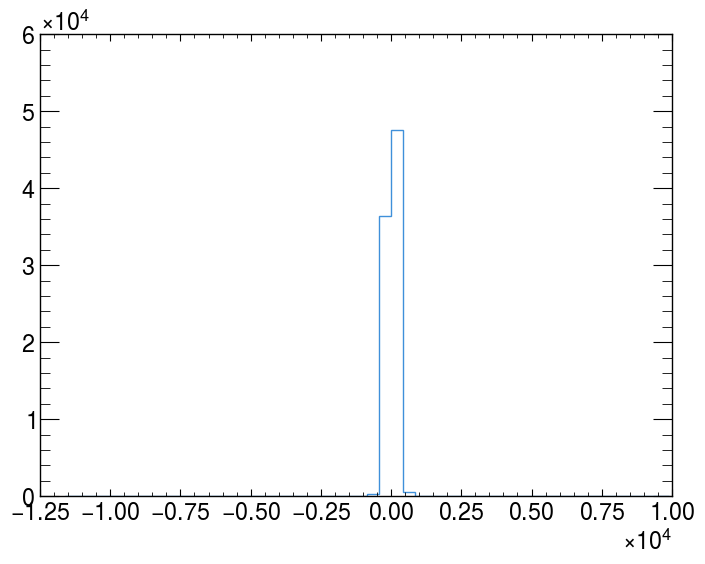

In [16]:
# neutrino mass checking
nu0_4vect = sig_pred_inv[:, :4] - test_x[:, :4]
nu1_4vect = sig_pred_inv[:, 4:8] - test_x[:, 4:8]
nu0_mass_squared = np.square(nu0_4vect[:, 3]) - np.square(nu0_4vect[:, 0]) - np.square(nu0_4vect[:, 1]) - np.square(nu0_4vect[:, 2])
nu1_mass_squared = np.square(nu1_4vect[:, 3]) - np.square(nu1_4vect[:, 0]) - np.square(nu1_4vect[:, 1]) - np.square(nu1_4vect[:, 2])
# nu0_mass_squared
plt.hist(nu0_mass_squared, bins=50, histtype="step", label="nu0_mass_squared")
# plt.hist(nu1_mass_squared, bins=100, range=(0, 100), histtype="step", label="nu1_mass_squared")


Truth mean: 0.031, std: 39.544, min: -585.857, max: 803.254


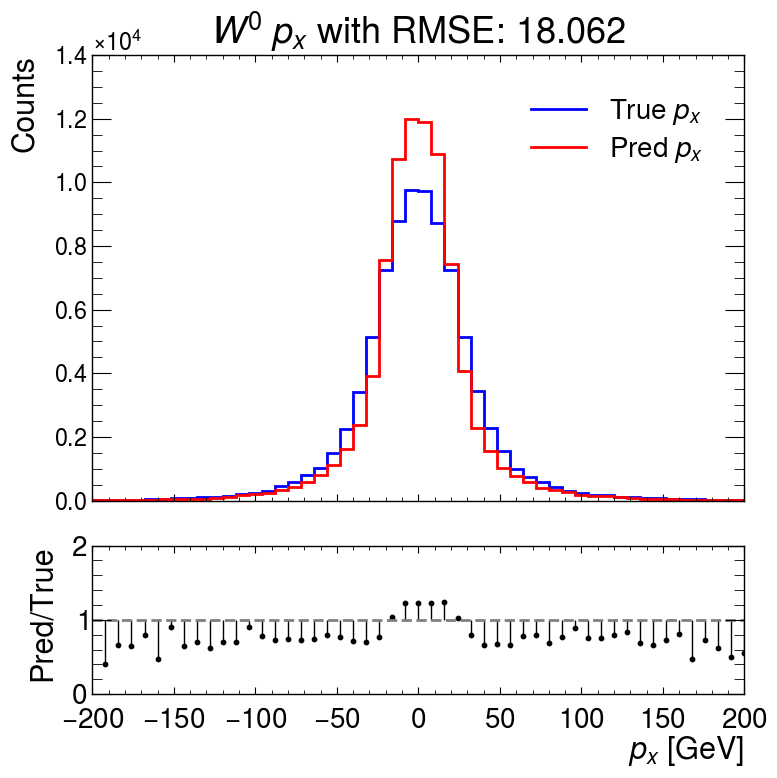

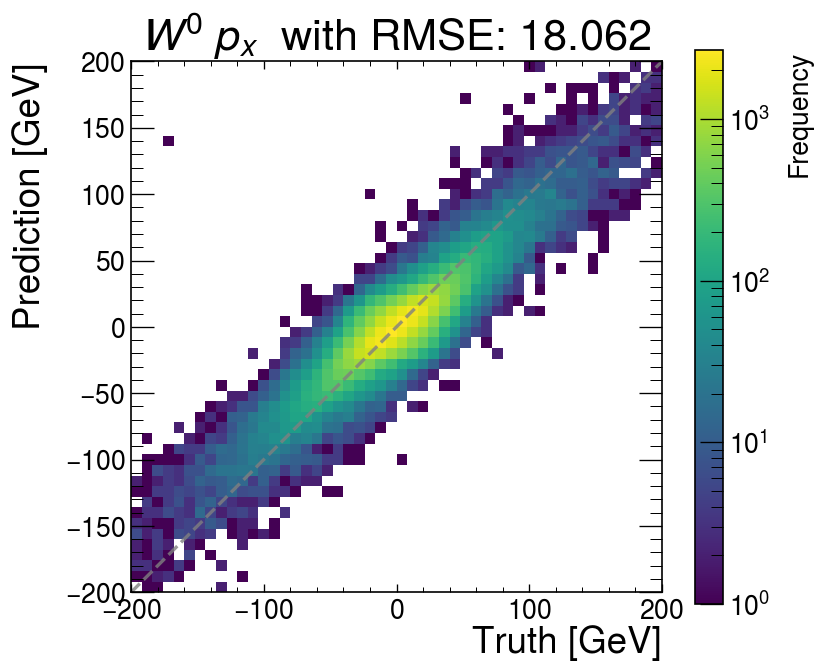

In [17]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 0], sig_pred_inv[:, 0]],
    label=r"$p_{x}$",
    title="$W^{0}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 0],
    sig_pred_inv[:, 0],
    r"$W^{0}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50,
)

Truth mean: -0.124, std: 27.801, min: -399.814, max: 373.865


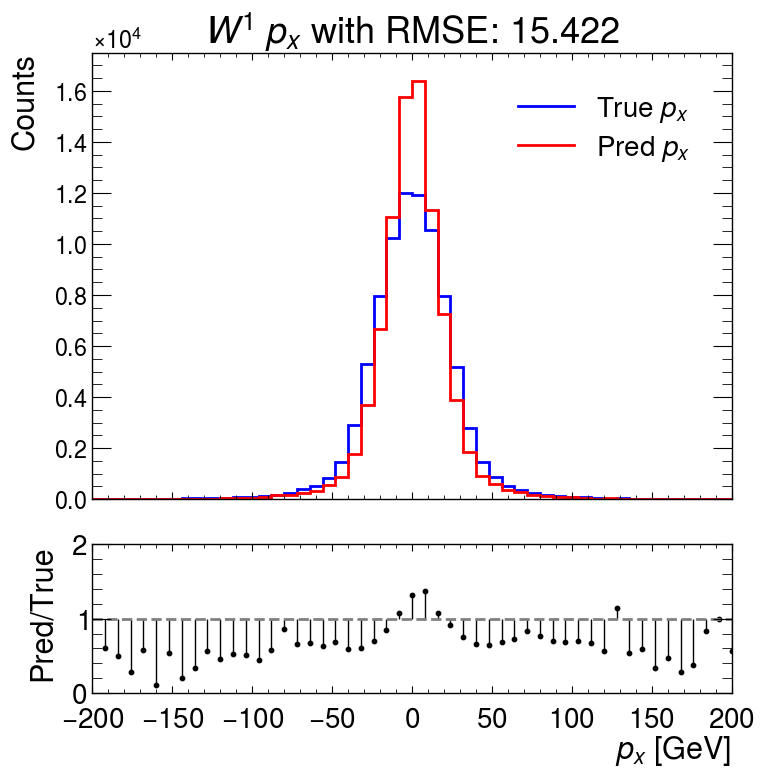

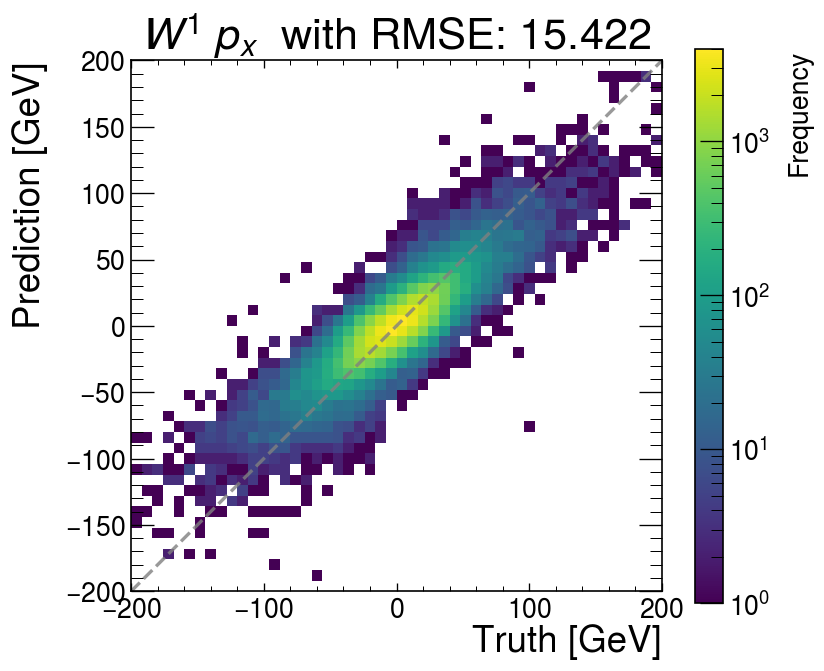

In [18]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 4], sig_pred_inv[:, 4]],
    label=r"$p_{x}$",
    title="$W^{1}$ $p_{x}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 4],
    sig_pred_inv[:, 4],
    r"$W^{1}$ $p_{x}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50 
)

Truth mean: -0.013, std: 39.620, min: -755.579, max: 609.143


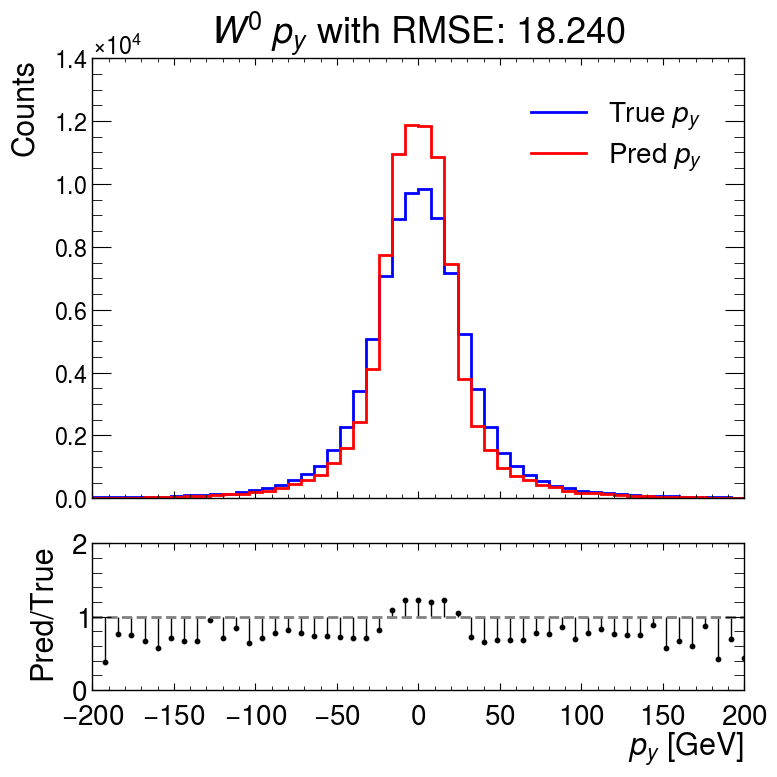

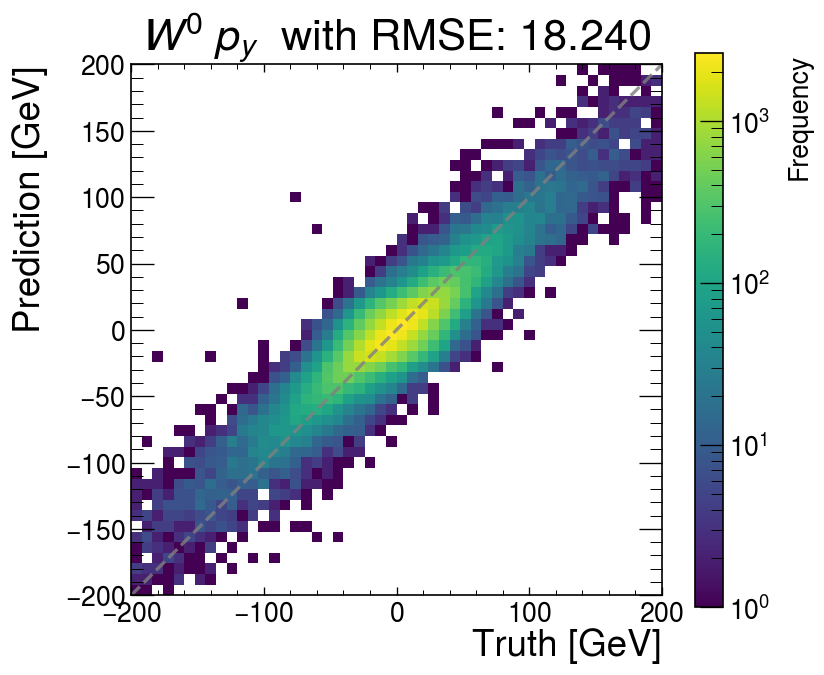

In [19]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 1], sig_pred_inv[:, 1]],
    label=r"$p_{y}$",
    title="$W^{0}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 1],
    sig_pred_inv[:, 1],
    r"$W^{0}$ $p_{y}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50 
)

Truth mean: 0.031, std: 27.968, min: -417.838, max: 580.447


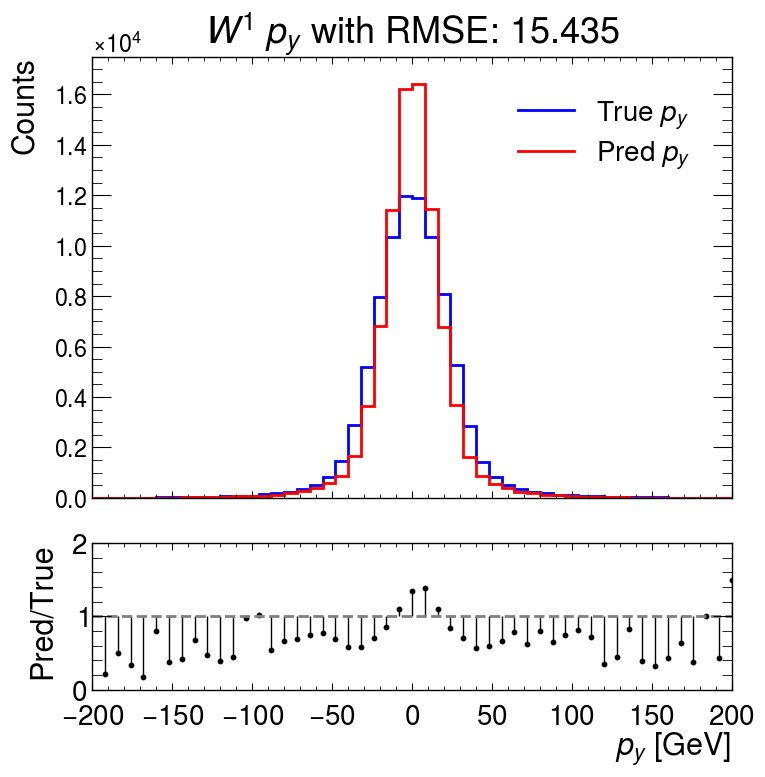

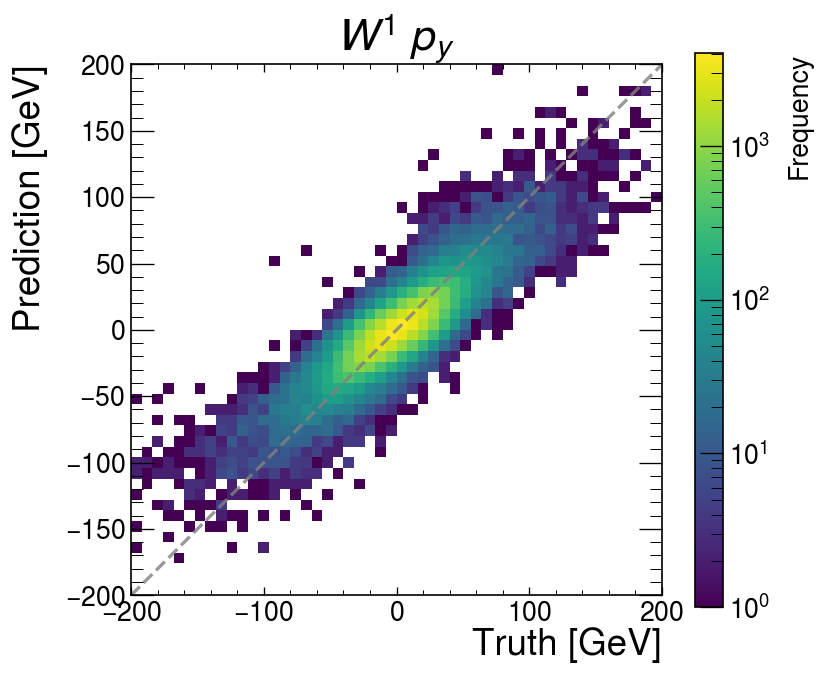

In [20]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist(
    data=[sig_truth_inv[:, 5], sig_pred_inv[:, 5]],
    label=r"$p_{y}$",
    title="$W^{1}$ $p_{y}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 5],
    sig_pred_inv[:, 5],
    r"$W^{1}$ $p_{y}$ ",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 0.308, std: 170.752, min: -1446.473, max: 1754.351


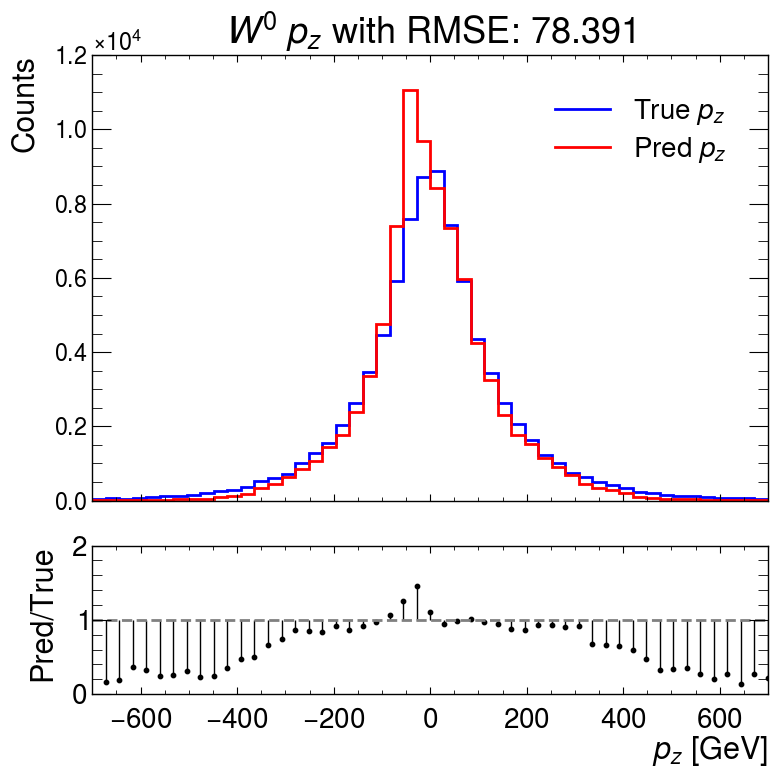

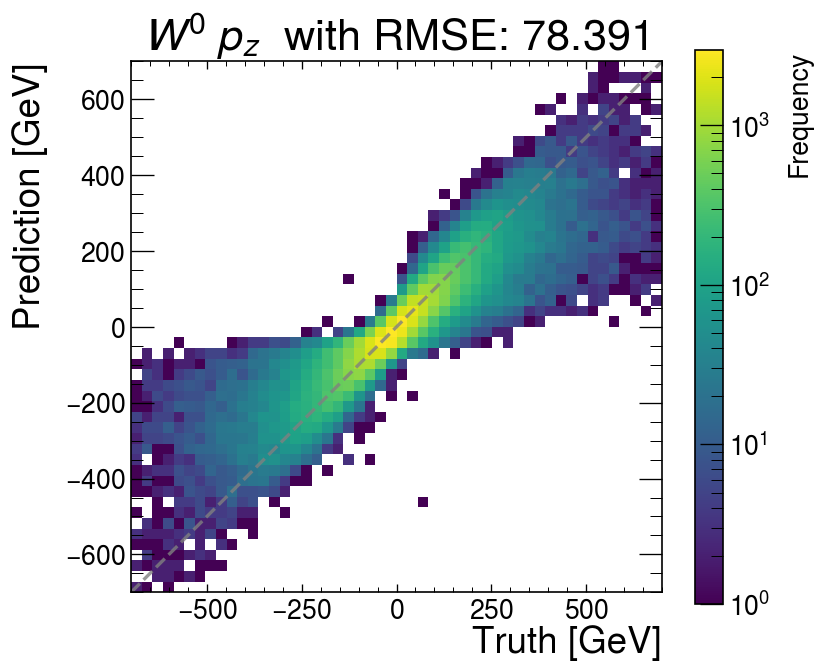

In [21]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist(
    data=[sig_truth_inv[:, 2], sig_pred_inv[:, 2]],
    label=r"$p_{z}$",
    title="$W^{0}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 2],
    sig_pred_inv[:, 2],
    r"$W^{0}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: -0.337, std: 110.947, min: -1170.774, max: 1427.069


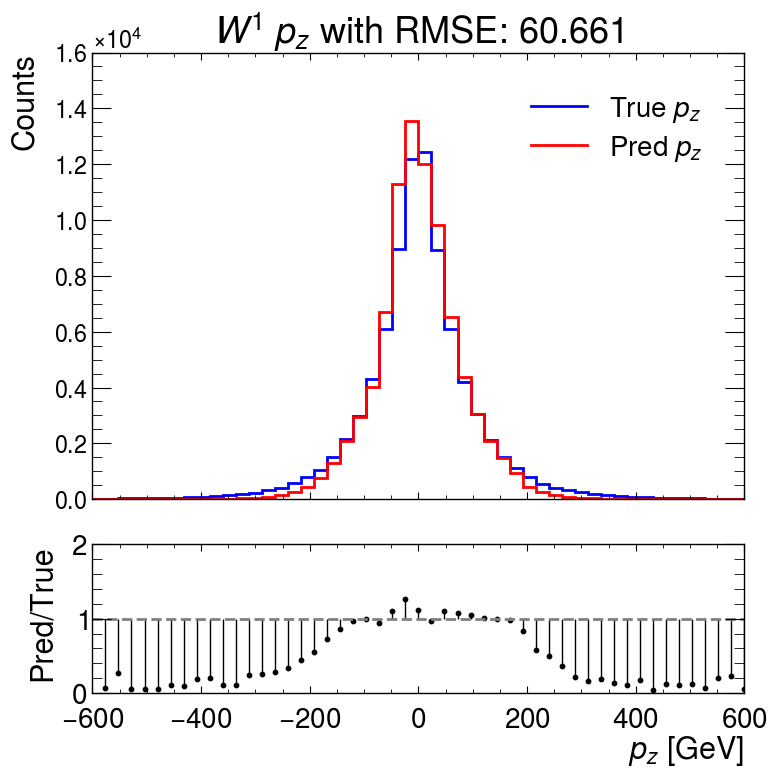

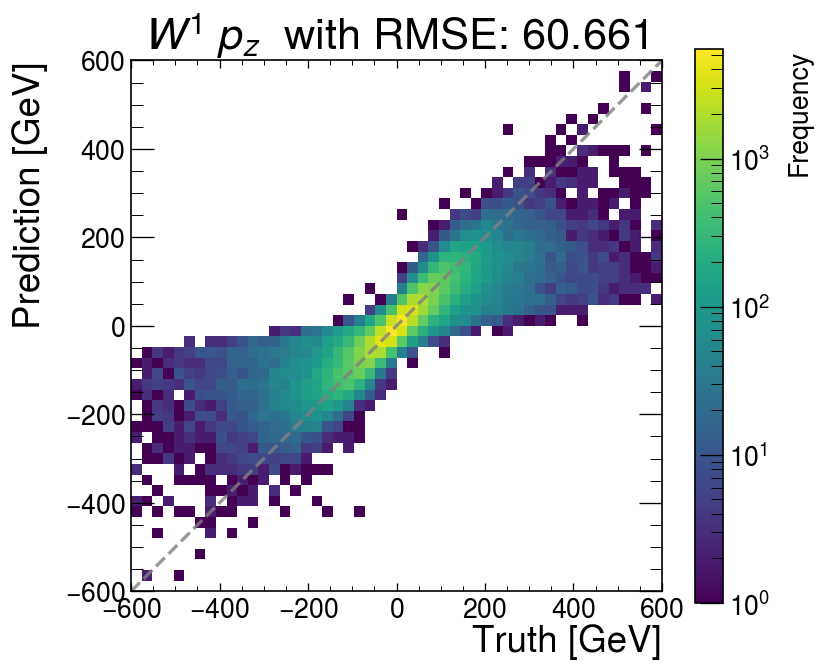

In [22]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist(
    data=[sig_truth_inv[:, 6], sig_pred_inv[:, 6]],
    label=r"$p_{z}$",
    title="$W^{1}$ $p_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 6],
    sig_pred_inv[:, 6],
    r"$W^{1}$ $p_{z}$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 158.446, std: 111.648, min: 21.707, max: 1791.292


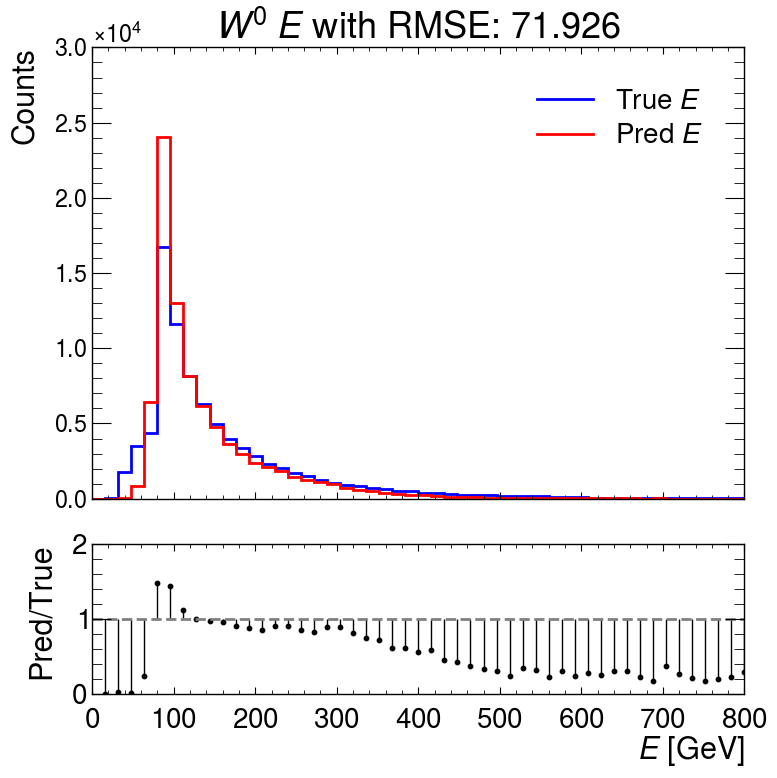

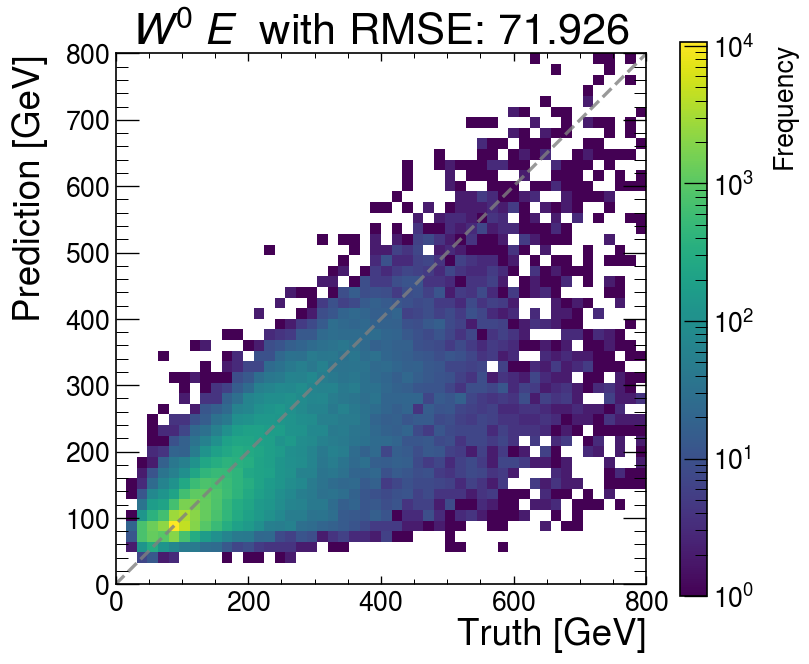

In [23]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 3], sig_pred_inv[:, 3]],
    label=r"$E$",
    title="$W^{0}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 3],
    sig_pred_inv[:, 3],
    r"$W^{0}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins = 50
)

Truth mean: 98.991, std: 77.608, min: 17.001, max: 1443.825


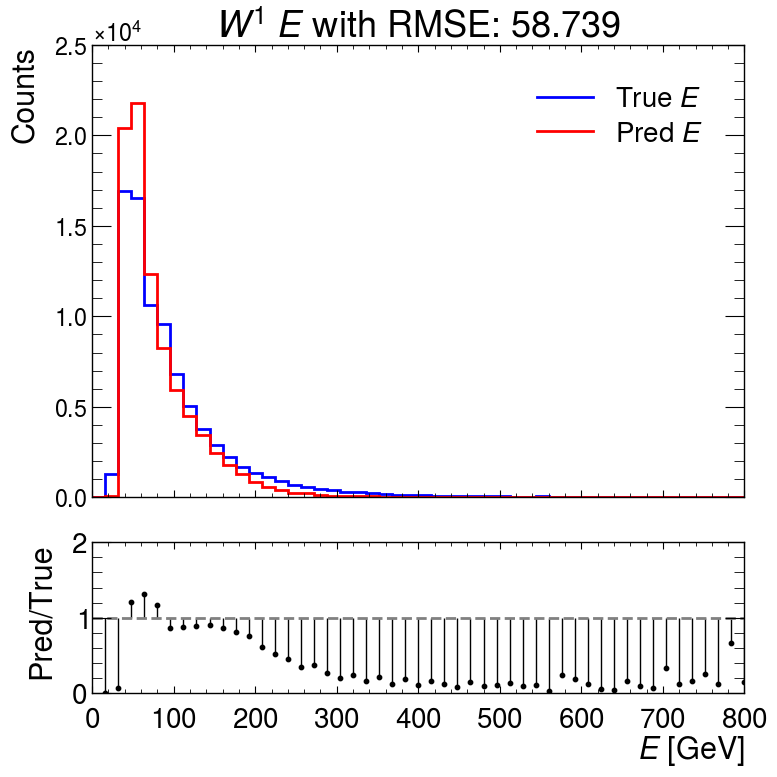

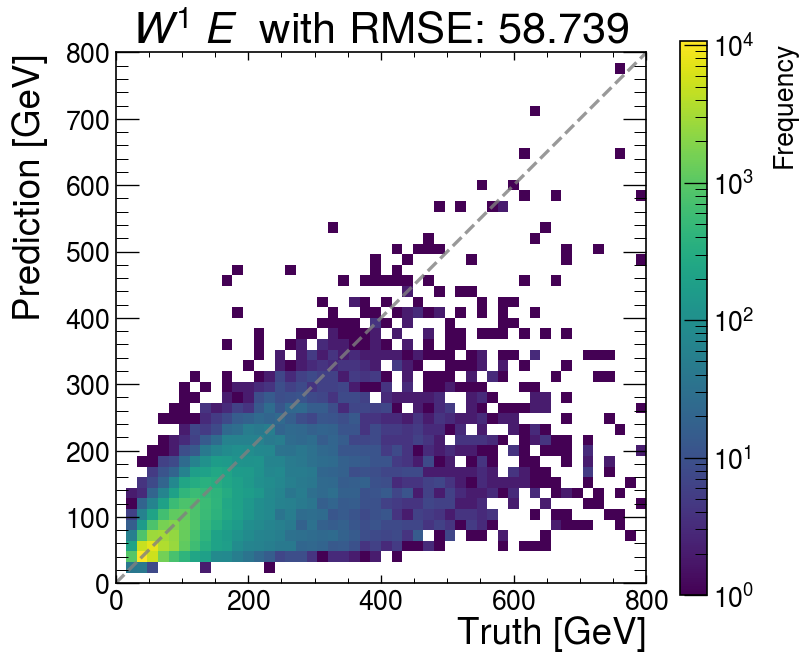

In [24]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist(
    data=[sig_truth_inv[:, 7], sig_pred_inv[:, 7]],
    label=r"$E$",
    title="$W^{1}$ $E$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    range=set_range,
    unit="[GeV]",
    weights=None,
)

plot.plot_2d_histogram(
    sig_truth_inv[:, 7],
    sig_pred_inv[:, 7],
    r"$W^{1}$ $E$ "
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    range=set_range,
    weights=None,
    bins=50,
)

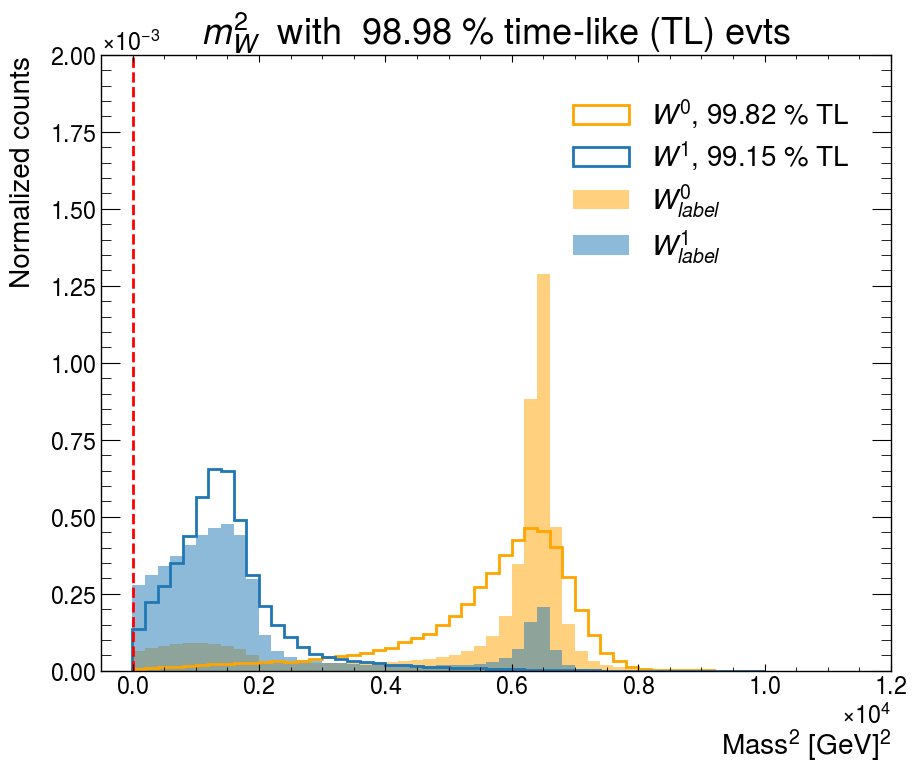

In [25]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like (TL) evts",
    fontsize=26,
    )
plt.legend(loc="upper right", prop={'size': 20})  # Adjust the size value as needed
plt.show()

Truth mean: 3615.291, std: 2594.373, min: 4.010, max: 11077.988


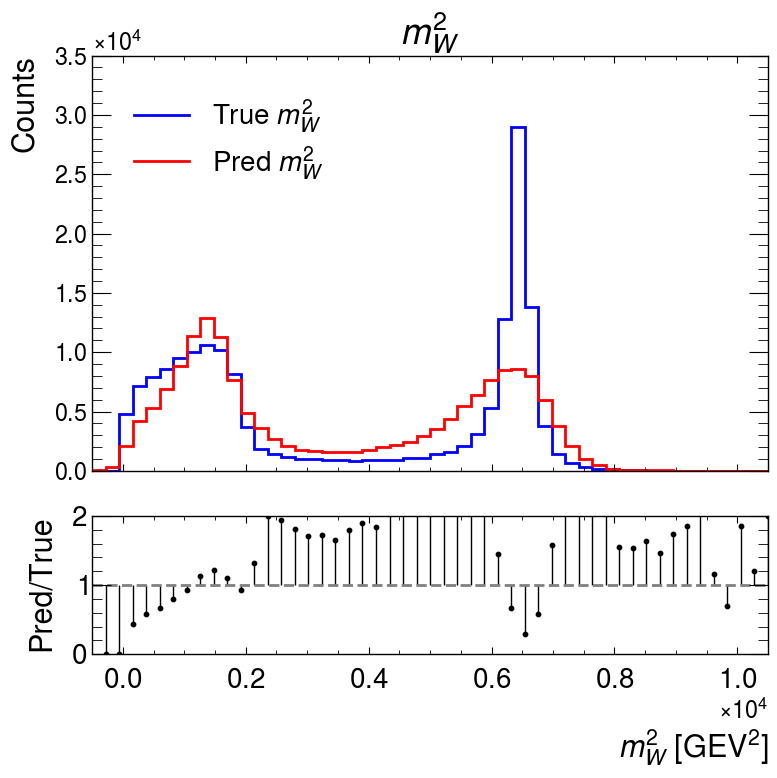

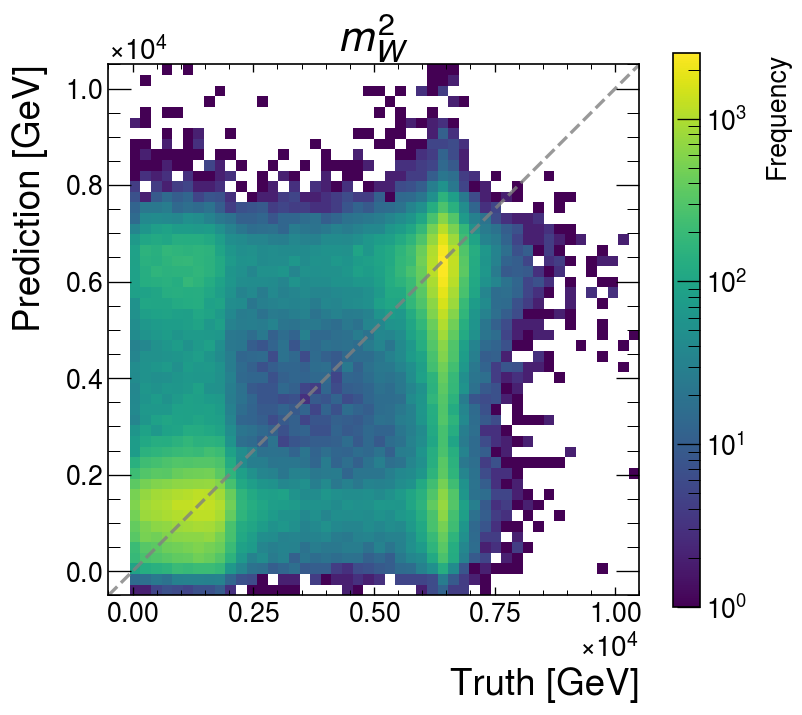

In [26]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]

plot.hist(
    data=[truth_m2, pred_m2],
    label=r"$m_{W}^{2}$",
    title="$m_{W}^{2}$",
    # # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    unit=r"[GEV$^{2}$]",
    xpad=24,
    # weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

plot.plot_2d_histogram(
    truth_m2,
    pred_m2,
    r"$m_{W}^{2}$ ",
    # + f" with RMSE: {np.sqrt(mean_squared_error(truth_m2, pred_m2)):.3f}",
    range=set_range,
    xpad=24,
    bins=50,
    # weights=np.append(mc_weight[test_indices], mc_weight[test_indices]),
)

In [27]:

# TODO: CGLMP

def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )
    
def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))
    
    # Unpack the results
    bij, xi_p, xi_n = zip(*results)
    
    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [28]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000,:]
xi_p = result_generator(particles)[1][0:80_000,:]
xi_n = result_generator(particles)[2][0:80_000,:]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000,:]
truth_xi_p = result_generator(particles)[1][0:80_000,:]
truth_xi_n = result_generator(particles)[2][0:80_000,:]

Truth mean    : 2.468, std: 12.019, min: -25.100, max: 29.607
Predicted mean: 10.673, std: 8.598, min: -24.990, max: 29.598


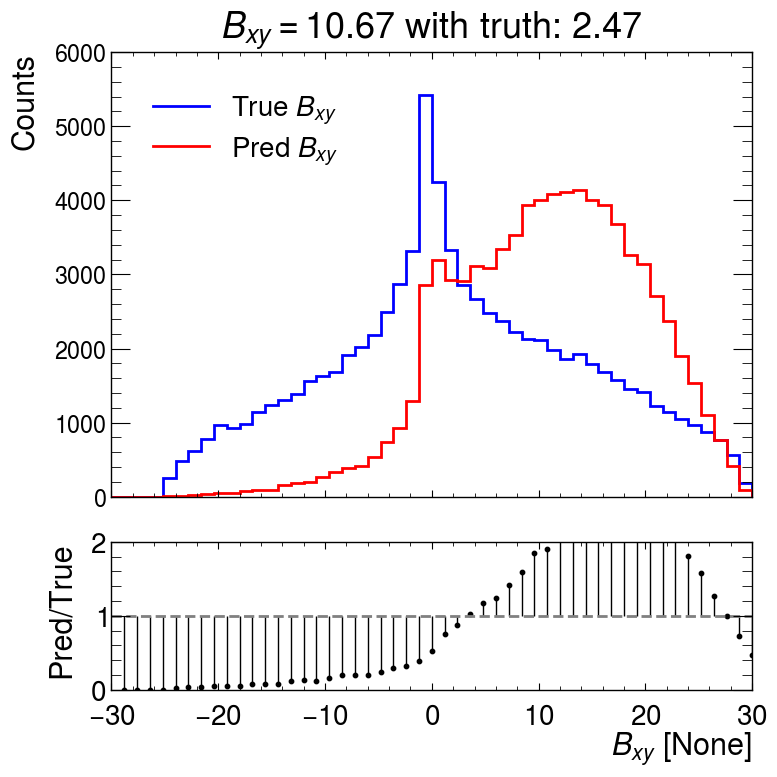

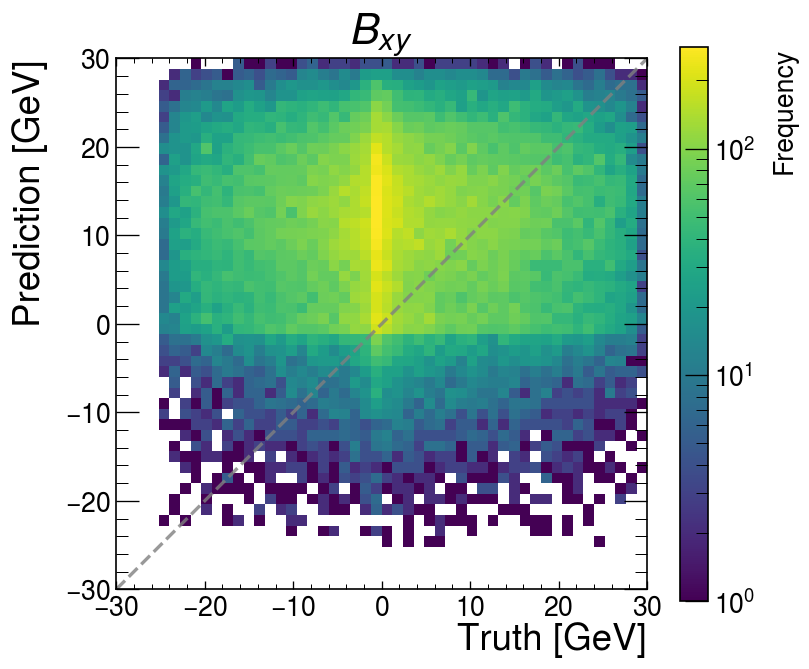

In [29]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,0]):.3f}, std: {np.std(truth_bij[:,0]):.3f}, min: {np.min(truth_bij[:,0]):.3f}, max: {np.max(truth_bij[:,0]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,0]):.3f}, std: {np.std(bij[:,0]):.3f}, min: {np.min(bij[:,0]):.3f}, max: {np.max(bij[:,0]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,0], bij[:,0]],
    label=r"$B_{xy}$",
    title=rf"$B_{{xy}}={np.mean(bij[:,0]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,0]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,0],
    bij[:,0],
    r"$B_{xy}$",
    range=set_range,
    weights=None,
    bins=50
)

Truth mean    : 2.060, std: 8.727, min: -25.095, max: 29.572
Predicted mean: 0.951, std: 7.280, min: -25.091, max: 29.537


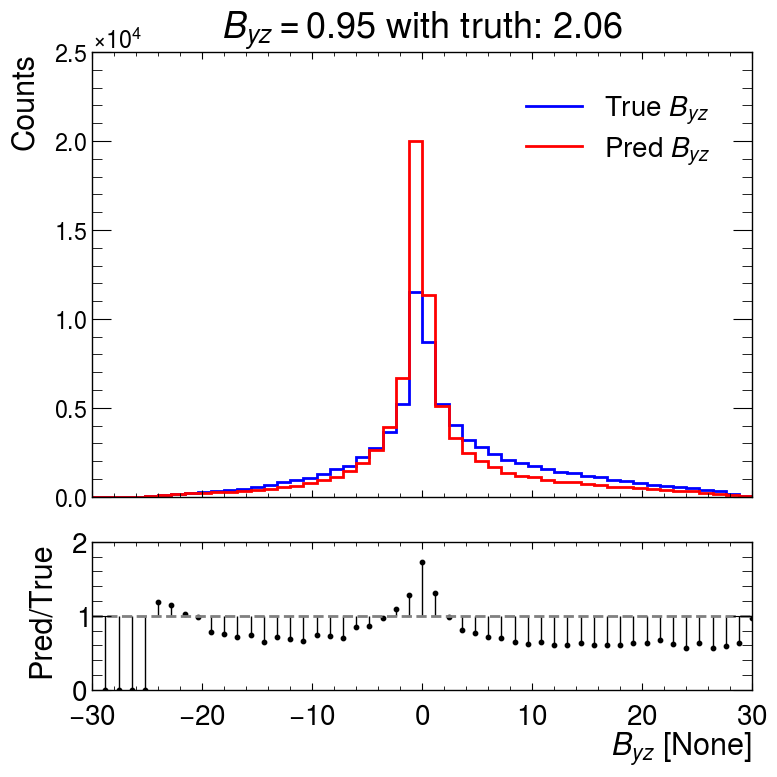

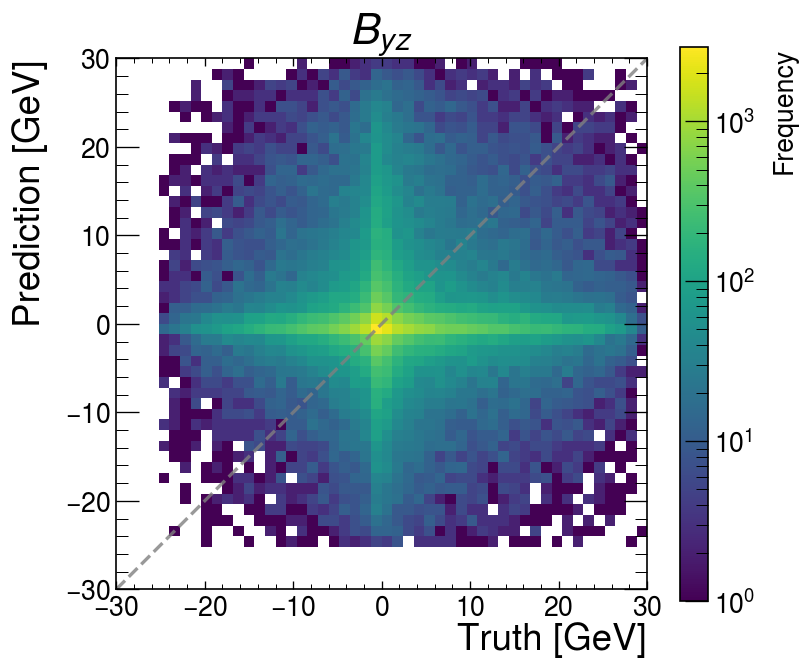

In [30]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,1]):.3f}, std: {np.std(truth_bij[:,1]):.3f}, min: {np.min(truth_bij[:,1]):.3f}, max: {np.max(truth_bij[:,1]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,1]):.3f}, std: {np.std(bij[:,1]):.3f}, min: {np.min(bij[:,1]):.3f}, max: {np.max(bij[:,1]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,1], bij[:,1]],
    label=r"$B_{yz}$",
    title=rf"$B_{{yz}}={np.mean(bij[:,1]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,1]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,1],
    bij[:,1],
    r"$B_{yz}$",
    range=set_range,
    weights=None,
    bins=50
)

Truth mean    : 3.228, std: 10.739, min: -25.073, max: 29.599
Predicted mean: 1.792, std: 13.386, min: -25.102, max: 29.584


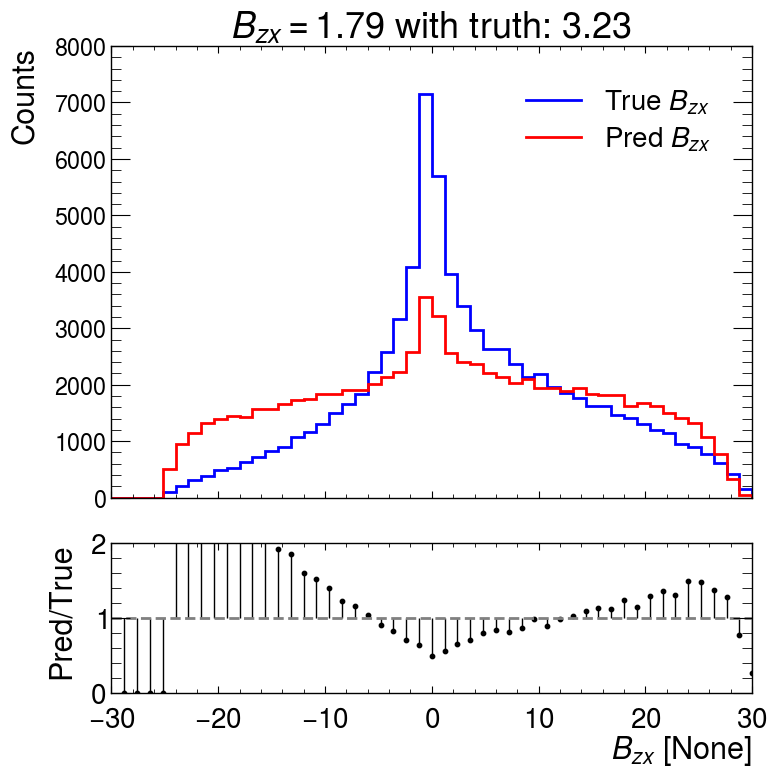

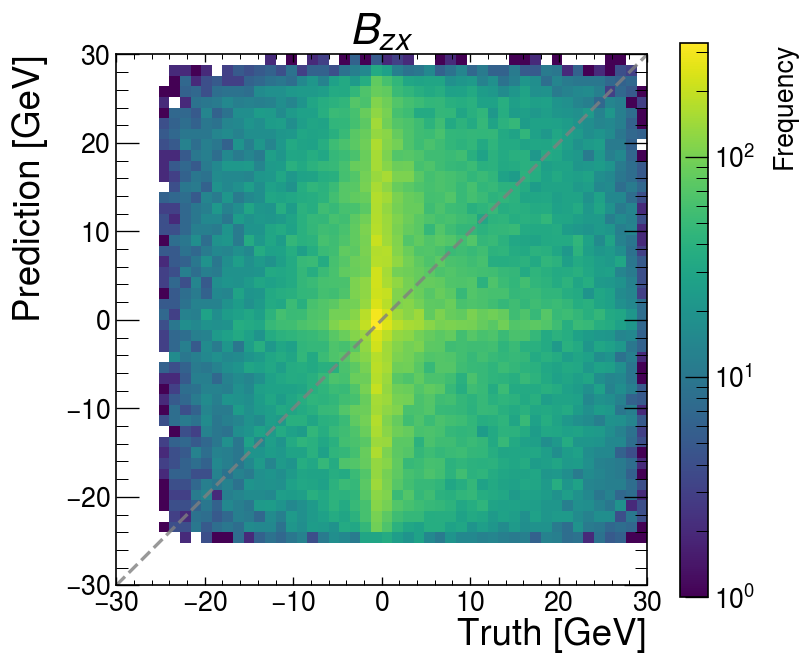

In [31]:

print(
    f"Truth mean    : {np.mean(truth_bij[:,2]):.3f}, std: {np.std(truth_bij[:,2]):.3f}, min: {np.min(truth_bij[:,2]):.3f}, max: {np.max(truth_bij[:,2]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,2]):.3f}, std: {np.std(bij[:,2]):.3f}, min: {np.min(bij[:,2]):.3f}, max: {np.max(bij[:,2]):.3f}"
)

set_range = [-30, 30]

plot.hist(
    data=[truth_bij[:,2], bij[:,2]],
    label=r"$B_{zx}$",
    title=rf"$B_{{zx}}={np.mean(bij[:,2]):.2f}$"
    + f" with truth: {np.mean(truth_bij[:,2]):.2f}",
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_bij[:,2],
    bij[:,2],
    r"$B_{zx}$",
    range=set_range,
    weights=None,
    bins=50
)

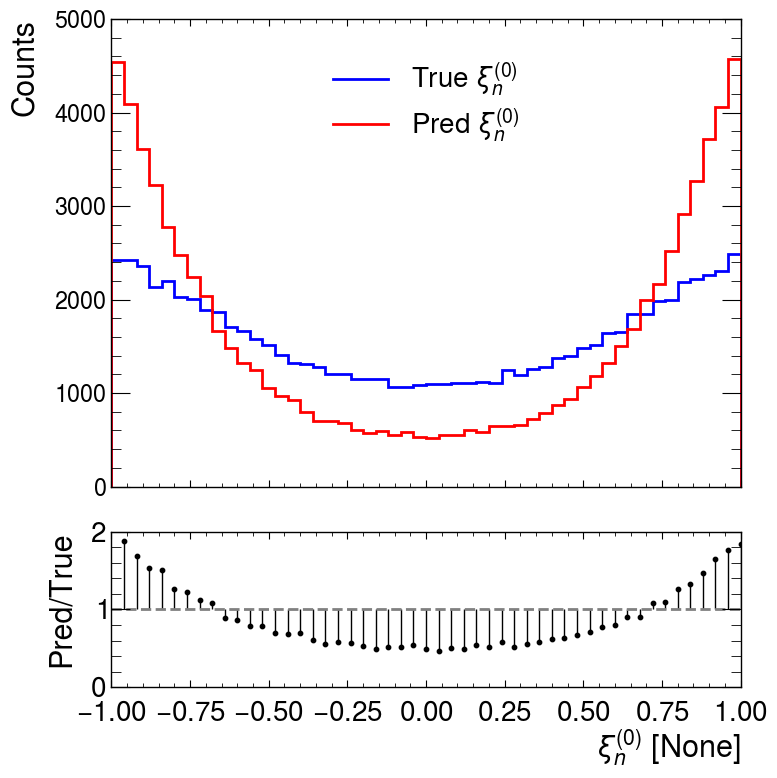

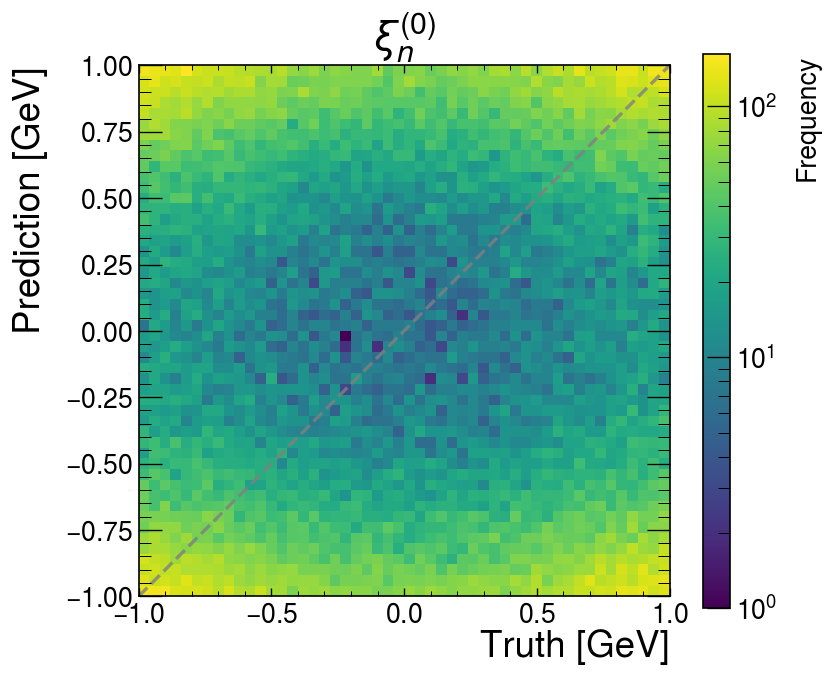

In [32]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,0], xi_p[:,0]],
    label=r"$\xi^{(0)}_{n}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,0],
    xi_p[:,0],
    r"$\xi^{(0)}_{n}$",
    range=set_range,
    weights=None,
    bins=50
)

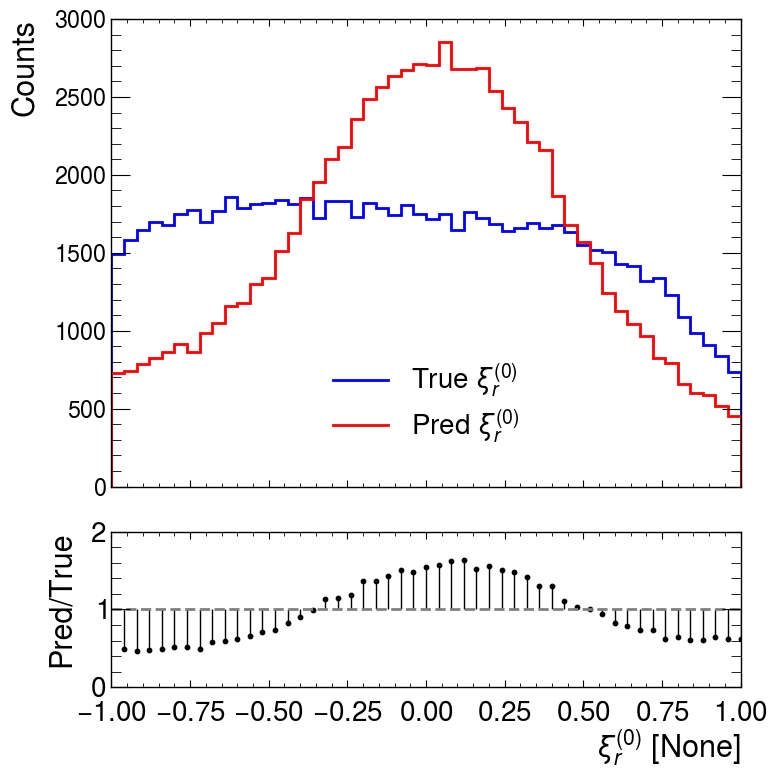

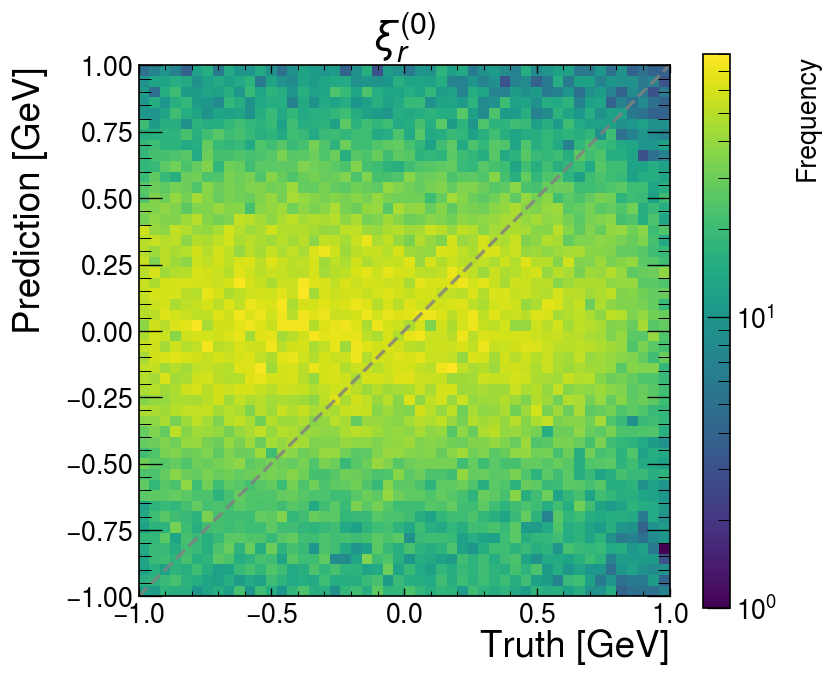

In [33]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,1], xi_p[:,1]],
    label=r"$\xi^{(0)}_{r}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,1],
    xi_p[:,1],
    r"$\xi^{(0)}_{r}$",
    range=set_range,
    weights=None,
    bins=50
)

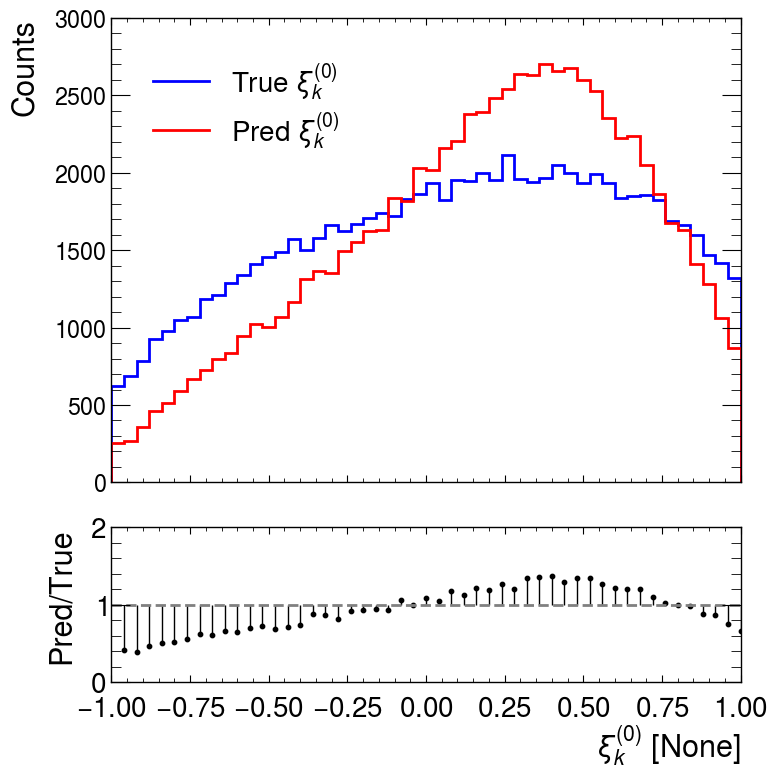

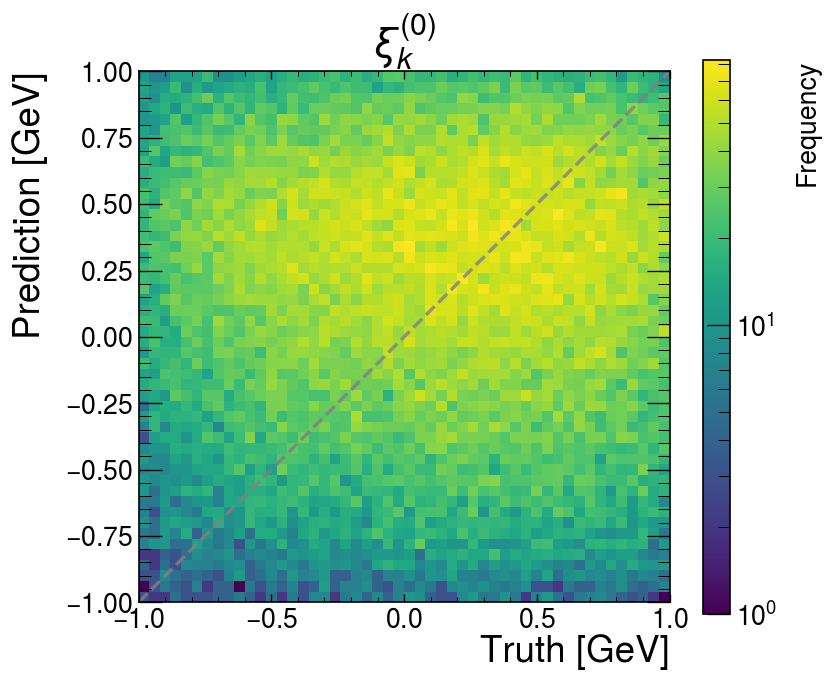

In [34]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_p[:,2], xi_p[:,2]],
    label=r"$\xi^{(0)}_{k}$",
    title=None,
    range=set_range,
    unit="[None]",
    weights=None,
)

plot.plot_2d_histogram(
    truth_xi_p[:,2],
    xi_p[:,2],
    r"$\xi^{(0)}_{k}$",
    range=set_range,
    weights=None,
    bins=50
)

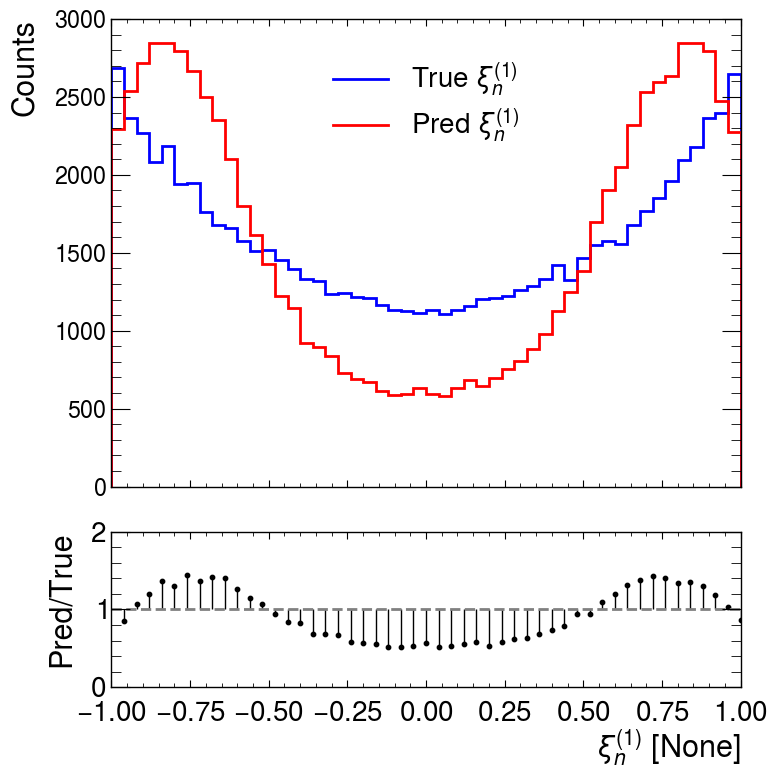

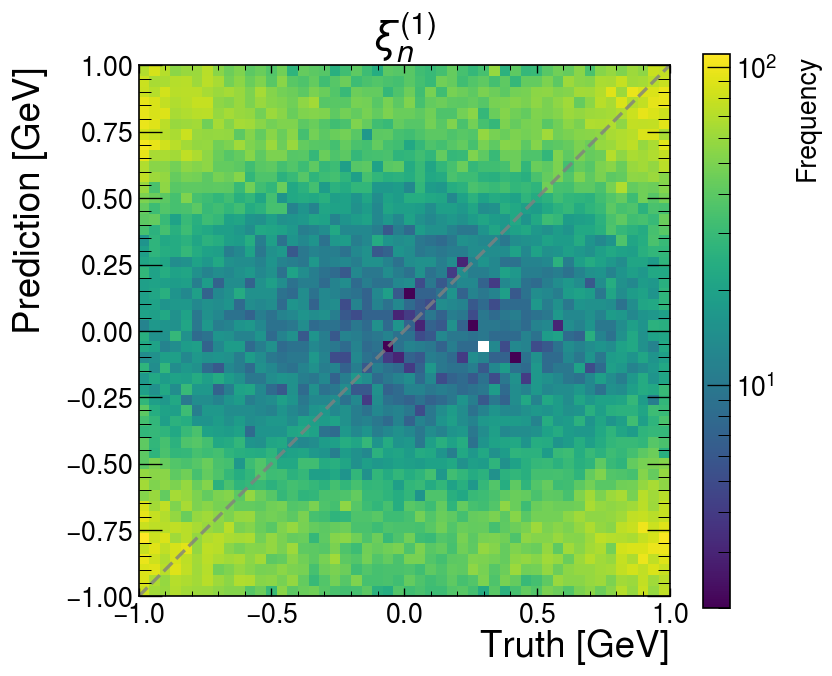

In [35]:
set_range = [-1, 1]

plot.hist(
    data=[truth_xi_n[:,0], xi_n[:,0]],
	label=r"$\xi^{(1)}_{n}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,0],
	xi_n[:,0],
	r"$\xi^{(1)}_{n}$",
	range=set_range,
	weights=None,
	bins=50
)

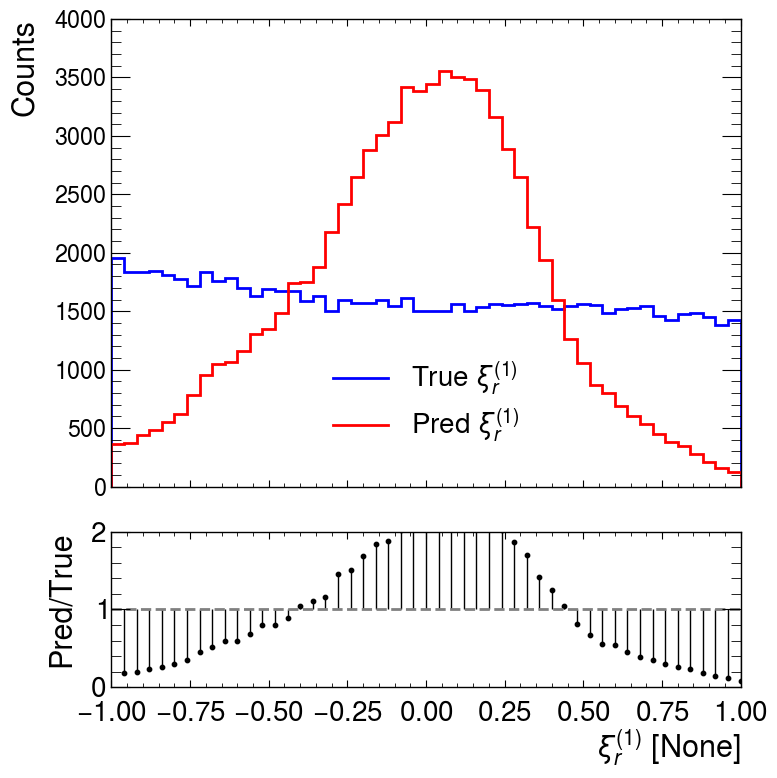

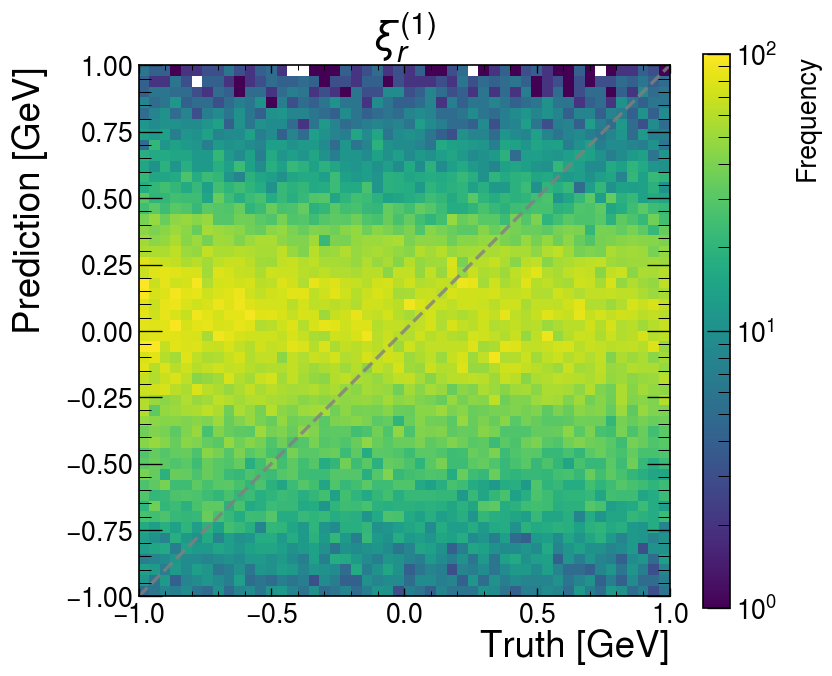

In [36]:
set_range = [-1, 1]

plot.hist(	
	data=[truth_xi_n[:,1], xi_n[:,1]],
	label=r"$\xi^{(1)}_{r}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,1],
	xi_n[:,1],
	r"$\xi^{(1)}_{r}$",
	range=set_range,
	weights=None,
	bins=50
)

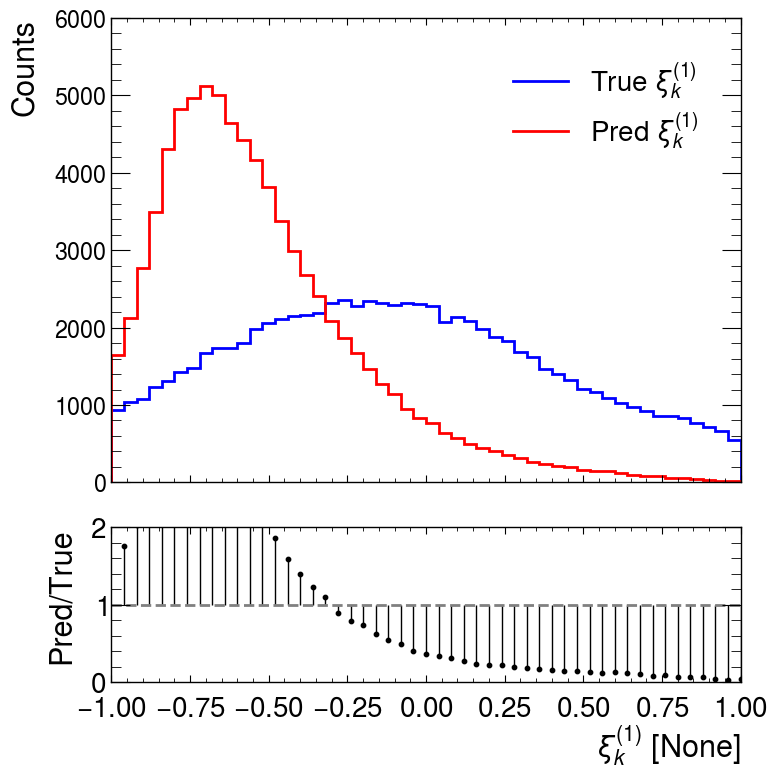

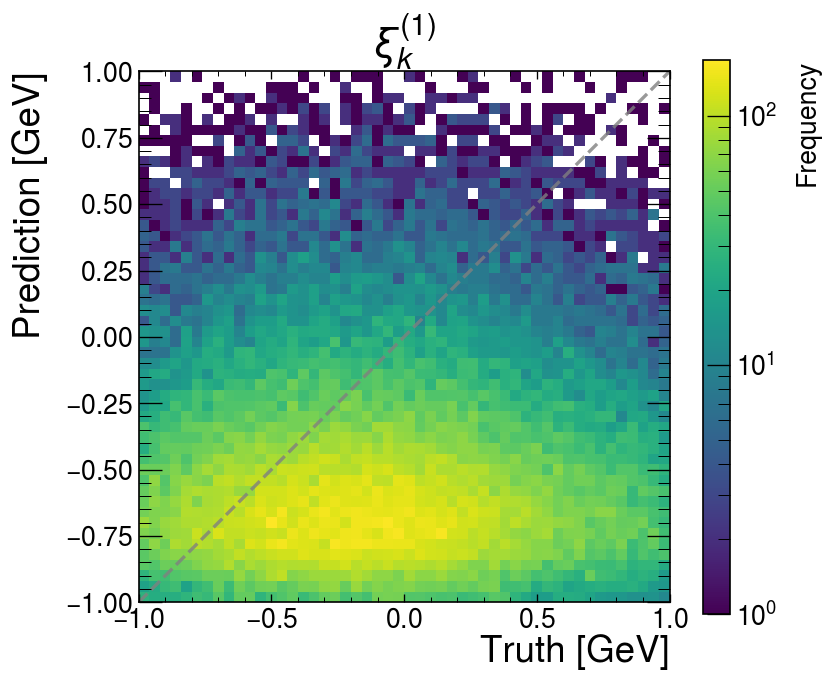

In [37]:
set_range = [-1, 1]

plot.hist(
	data=[truth_xi_n[:,2], xi_n[:,2]],
	label=r"$\xi^{(1)}_{k}$",
	title=None,
	range=set_range,
	unit="[None]",
	weights=None,
)

plot.plot_2d_histogram(
	truth_xi_n[:,2],
	xi_n[:,2],
	r"$\xi^{(1)}_{k}$",
	range=set_range,
	weights=None,
	bins=50
)